In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
import seaborn as sns

# Processing Data

In [2]:
def get_all_stock():
    con = db.create_engine("sqlite:///C:/Users/zheji/Desktop/TradingTools/dailyDB.sqlite")
    dfs = []
    for table in con.table_names():
        tmp = pd.read_sql(table, con)
        tmp['ticker'] = table
        tmp['1dayret%'] = (tmp['Adj Close'] - tmp['Adj Close'].shift(1))/tmp['Adj Close'].shift(1) * 100
        tmp['nextdayret%'] = (tmp['Adj Close'].shift(-1) - tmp['Adj Close'])/ tmp['Adj Close'] * 100
        tmp['relativeVol'] = tmp['Volume'] / tmp['Volume'].rolling(20).mean()
        tmp['nextdayret_stdmove'] = tmp['nextdayret%'] / tmp['nextdayret%'].std()
        dfs.append(tmp)
    return pd.concat(dfs)
stock_df = get_all_stock()

In [3]:
con1 = db.create_engine('sqlite:///'+'shortDB'+'.sqlite')
ts = pd.read_sql_query('SELECT * from DARK', con1)
con2 = db.create_engine('sqlite:///'+'shortDB'+'.sqlite')
ts_lit = pd.read_sql_query('SELECT * from Lit', con2)
ts = ts.drop_duplicates()
ts_lit = ts_lit.drop_duplicates()

In [4]:
short = pd.merge(ts, ts_lit, left_on=['Date', 'Symbol'], right_on=['Date', 'Symbol'], how='inner')  # cboe + finra 
view = pd.merge(short, stock_df, left_on=['Date', 'Symbol'], right_on=['Date', 'ticker'], how='inner') # cboe + finra + stock

In [5]:
view['Lit_VolumeRatio'] = view['CBOE_TotalVolume']/view['Volume']
view['Dark_VolumeRatio'] = view['NMS_TotalVolume']/view['Volume']
view.head(5)

,index_x,Symbol,NASDAQCAR_ShortVolume,NASDAQCAR_TotalVolume,NYSE_ShortVolume,NYSE_TotalVolume,Date,NMS_ShortVolume,NMS_TotalVolume,NASDAQCAR_ShortRatio,...,Low,Close,Adj Close,Volume,ticker,1dayret%,nextdayret%,relativeVol,Lit_VolumeRatio,Dark_VolumeRatio
0,0,A,89508.0,412346.0,36071.0,146290.0,2019-02-20,125579.0,558636.0,0.217070,...,77.330002,78.559998,77.697357,2076500.0,A,1.341609,-0.852852,1.137522,0.125743,0.269028
1,5,AAL,844109.0,1372781.0,319835.0,584804.0,2019-02-20,1163944.0,1957585.0,0.614890,...,34.770000,35.060001,34.596169,6969900.0,AAL,-1.155894,-0.228190,0.823234,0.165140,0.280863
2,9,AAP,272139.0,469307.0,18423.0,54741.0,2019-02-20,290562.0,524048.0,0.579874,...,162.589996,166.000000,165.279968,1990200.0,AAP,-0.682054,-2.825314,1.536176,0.123362,0.263314
3,10,AAPL,2626567.0,5520623.0,1587174.0,3256997.0,2019-02-20,4213741.0,8777620.0,0.475774,...,170.990005,172.029999,169.807388,26114400.0,AAPL,0.643545,-0.563850,0.880578,0.121747,0.336122
4,18,ABBV,435128.0,1587068.0,39094.0,260434.0,2019-02-20,474222.0,1847502.0,0.274171,...,79.139999,79.989998,73.424461,5564100.0,ABBV,-0.658219,-1.550194,0.690914,0.118325,0.332040


In [6]:
view = view[abs(view['1dayret%']) < 50]
view = view[abs(view['nextdayret%']) < 50]

# Machine Learning Experiment

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
print(view.shape)
view = view[~view.isin([np.nan, np.inf, -np.inf]).any(1)]
print(view.shape)
features = ['NMS_ShortRatio', 'CBOE_ShortRatio', 'Lit_VolumeRatio', 'Dark_VolumeRatio', '1dayret%']
view['classification'] = np.where(view['nextdayret%']>1, 1, np.where(view['nextdayret%']<-1, -1, 0))
label = 'classification'
train = view[view['Date'] < '2020-02-15']
test = view[view['Date'] > '2020-02-15']
train_X = train[features]
#train_X = preprocessing.scale(train_X)
train_Y = train[label]
test_X = test[features]
#test_X = preprocessing.scale(test_X)
test_Y = test[label]

(138448, 43)
(138448, 43)


In [60]:
model = LinearRegression()
model.fit(train_X, train_Y)
model.score(test_X, test_Y)

-0.0017284496993419385

In [61]:
model = RandomForestClassifier(n_estimators=200)
model.fit(train_X, train_Y)
model.score(test_X, test_Y)

0.2732590020106013

In [62]:
confusion_matrix(test_Y, model.predict(test_X))

array([[ 1663, 11227,  2315],
       [  598,  6748,   900],
       [ 1564, 11228,  2054]], dtype=int64)

In [63]:
result = pd.DataFrame()
result['actual'] = test_Y
result['predict'] = model.predict(test_X)
result['ret'] = view['nextdayret%']
result.head(5)

,actual,predict,ret
100159,0,0,0.660446
100160,-1,0,-1.047849
100161,-1,0,-1.191737
100162,1,-1,1.448274
100163,0,0,0.566176


In [64]:
result.groupby('predict').ret.mean()

predict
-1   -0.102048
 0    0.024909
 1   -0.078132
Name: ret, dtype: float64

In [71]:
result.groupby('predict').ret.std()

predict
-1    6.948320
 0    4.896743
 1    5.989853
Name: ret, dtype: float64

In [66]:
result.groupby('predict').ret.count()

predict
-1     3825
 0    29203
 1     5269
Name: ret, dtype: int64

In [67]:
result.groupby('predict').ret.max()

predict
-1    42.192346
 0    41.097036
 1    41.015989
Name: ret, dtype: float64

In [68]:
result.groupby('predict').ret.min()

predict
-1   -46.852121
 0   -37.755270
 1   -44.645802
Name: ret, dtype: float64

In [69]:
result.groupby('predict').ret.quantile(0.05)

predict
-1   -11.161714
 0    -7.552218
 1    -9.260840
Name: ret, dtype: float64

In [70]:
result.groupby('predict').ret.quantile(0.95)

predict
-1    11.082019
 0     7.718538
 1     9.413094
Name: ret, dtype: float64

# Quantile Research On DIX

In [ ]:
dix_bin_ret = {}
dp_vol = {}
tickers = ['FB', 'AAPL', 'NFLX', 'CAT', 'MMM', 'JNJ', 'NVDA', 'AMD', 'AMZN']

for ticker in tickers:
    aapl = ts[ts['Symbol']==ticker]
    aapl = pd.merge(aapl, stock_df[stock_df['Ticker']==ticker], on ='Date', how='inner')
    aapl.index = aapl['Date']
    aapl['nextday_ret'] = (aapl['Close'].shift(-1) - aapl['Close']) / aapl['Close'] * 100
    aapl['darkPoolRatio'] = aapl['NMS_TotalVolume'] / aapl['Volume']
    bin_labels = [i for i in range(5)]
    aapl['bin'] = pd.qcut(aapl['NMS_ShortRatio'], q=5, labels=bin_labels)
    dp_vol[ticker] = aapl.groupby('bin').darkPoolRatio.mean()
    dix_bin_ret[ticker] = aapl.groupby('bin').nextday_ret.std()
#     aapl['NMS_ShortRatio'].plot(figsize=(20,10), grid=True)
#     plt.show()
#     aapl['nextday_ret'].plot(figsize=(20,10), grid=True)

c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

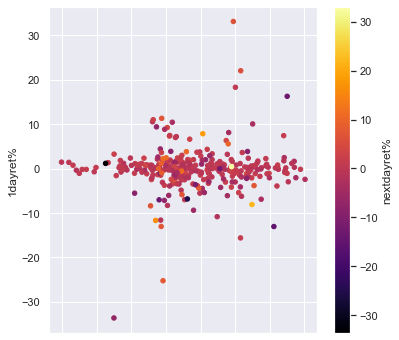

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.090810           5.788492     -1.088339          6.986122
1              -0.176724           4.524789      1.042930          5.938374
2              -0.260062           3.888980     -0.105484          3.109686
3               0.079944           5.608566     -0.112317          2.098426
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
146118     4701    MGM              2242496.0              5368073.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
146118         1113700.0         2659203.0  2020-07-09        3367969.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close      Volume  \
146118        8067683.0              0.417747  ...       16.0  20028562.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
146118     MGM -1.8

c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

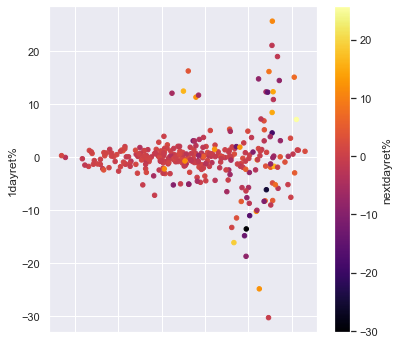

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.019622           1.494820     -0.178179          6.999994
1              -0.053692           3.579443      0.086429          5.423524
2              -0.260265           4.370324     -0.943473          3.586349
3              -0.592471           9.032031      0.157794          4.813033
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
146253     7421    UAL             13741942.0             19939704.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
146253         7841828.0        12126412.0  2020-07-09       21720542.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close      Volume  \
146253       32290209.0              0.689175  ...      30.17  52657634.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
146253     UAL -7.2

c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

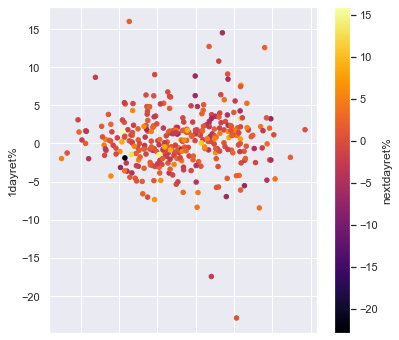

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.415640           4.353285      0.934540          3.702363
1               0.665185           3.099978      0.709170          3.114203
2               0.293946           3.496320     -0.104043          4.102517
3               0.194022           4.078920      0.032460          4.075738
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
146168     5602    PDD              1245482.0              2457735.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
146168          359209.0          709497.0  2020-07-09        1626807.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
146168        3237228.0               0.50676  ...      90.25  8743454.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
146168     PDD -2.231

c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
c:\users\zheji\anaconda3\envs\research\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

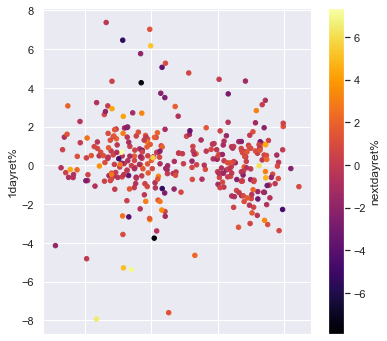

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.531918           1.993893      0.019589          1.318424
1               0.214149           2.387724      0.224333          1.947957
2              -0.152265           1.071965      0.388999          2.050617
3               0.281611           1.735417      0.249114          2.071171
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145876      363   AMZN               731183.0              1921968.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145876          437199.0          902102.0  2020-07-09        1186545.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...    Adj Close     Volume  \
145876        2855150.0              0.380435  ...  3182.629883  6304219.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145876    AMZN  3

In [52]:
def ret_heatmap(df):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(20,10)) 
    sns.heatmap(df, annot=True, cmap='RdYlGn', ax=ax)
    plt.show()
all_pred = []
sns.set(rc={'figure.figsize':(6,6)})
tickers = ['AAPL', 'SHOP', 'SPY', 'QQQ']
#tickers = ['AAPL', 'FB', 'NVDA']
tickers = ['MGM', 'UAL', 'PDD', 'AMZN']
for ticker in tickers:
    df = view[view['Symbol'] == ticker]
    bin_labels = [i for i in range(4)]
    df['FINRA_bin'] = pd.qcut(df['NMS_ShortRatio'], q=4, labels=bin_labels)
    df['CBOE_bin'] = pd.qcut(df['CBOE_ShortRatio'], q=4, labels=bin_labels)
    df['ret_bin'] = pd.qcut(df['1dayret%'], q=4, labels=bin_labels)
    today = df[df['Date'] == today_date]
    obs_num = df.shape[0]/16
    if today.shape[0] == 0:
        continue
    df.plot.scatter('NMS_ShortRatio', '1dayret%', c='nextdayret%', colormap='inferno')
    plt.show()
    stats = pd.DataFrame()
    stats['FINRA_bin_ret'] = df.groupby('FINRA_bin')['nextdayret%'].mean()
    stats['FINRA_bin_ret_std'] = df.groupby('FINRA_bin')['nextdayret%'].std()
    stats['CBOE_bin_ret'] = df.groupby('CBOE_bin')['nextdayret%'].mean()
    stats['CBOE_bin_ret_std'] = df.groupby('CBOE_bin')['nextdayret%'].std()
    print(stats)
    
    
#     cutoffs = pd.DataFrame()
#     cutoffs['FINRA'] = df.groupby(['FINRA_bin'])['NMS_ShortRatio'].max()
#     cutoffs['CBOE'] = df.groupby(['CBOE_bin'])['CBOE_ShortRatio'].max()
#     cutoffs['RET'] = df.groupby(['ret_bin'])['1dayret%'].max()
#     print(cutoffs)
    
    groupdf = df.groupby(['FINRA_bin', 'ret_bin'])
    twod_grid_ret = pd.DataFrame()
    twod_grid_std = pd.DataFrame()
    for i in range(4):
        twod_grid_ret['FINRA_bin_'+str(i)] = groupdf['nextdayret%'].median().loc[i]
        twod_grid_std['FINRA_bin_'+str(i)] = groupdf['nextdayret%'].std().loc[i]
    print(today)
    est_mean = twod_grid_ret.iloc[today['ret_bin'], today['FINRA_bin']].values[0,0]
    est_std = twod_grid_std.iloc[today['ret_bin'], today['FINRA_bin']].values[0,0]
    print(today)
    pred_dict = {'Ticker':ticker}
    pred_dict['NMS_VolRatio'] = (today['NMS_ShortVolume'] / today['Volume']).values[0]
    pred_dict['CBOE_VolRatio'] = (today['CBOE_ShortVolume'] / today['Volume']).values[0]
    pred_dict['relative_vol'] = today['relativeVol'].values[0]
    pred_dict['FINRA_EST'] = est_mean
    pred_dict['FINRA_RANGE_LOW'] = est_mean - 2* est_std/(obs_num ** 0.5)
    pred_dict['FINRA_RANGE_HIGH'] = est_mean + 2* est_std/(obs_num ** 0.5)
#     ret_heatmap(twod_grid_ret)
#     ret_heatmap(twod_grid_std)
    
    
    groupdf = df.groupby(['CBOE_bin', 'ret_bin'])
    twod_grid_ret = pd.DataFrame()
    twod_grid_std = pd.DataFrame()
    for i in range(4):
        twod_grid_ret['CBOE_bin_'+str(i)] = groupdf['nextdayret%'].median().loc[i]
        twod_grid_std['CBOE_bin_'+str(i)] = groupdf['nextdayret%'].std().loc[i]
    est_mean = twod_grid_ret.iloc[today['ret_bin'], today['CBOE_bin']].values[0,0]
    est_std = twod_grid_std.iloc[today['ret_bin'], today['CBOE_bin']].values[0,0]
    pred_dict['CBOE_EST'] = est_mean
    pred_dict['CBOE_RANGE_LOW'] = est_mean - 2* est_std/(obs_num ** 0.5)
    pred_dict['CBOE_RANGE_HIGH'] = est_mean + 2* est_std/(obs_num ** 0.5)
    all_pred.append(pred_dict)
    #ret_heatmap(twod_grid_ret)
    #ret_heatmap(twod_grid_std)

In [41]:
view.columns

Index(['index_x', 'Symbol', 'NASDAQCAR_ShortVolume', 'NASDAQCAR_TotalVolume',
       'NYSE_ShortVolume', 'NYSE_TotalVolume', 'Date', 'NMS_ShortVolume',
       'NMS_TotalVolume', 'NASDAQCAR_ShortRatio', 'NASDAQCHI_ShortRatio',
       'NASDAQCHI_ShortVolume', 'NASDAQCHI_TotalVolume', 'NYSE_ShortRatio',
       'NMS_ShortRatio', 'index_y', 'BZX_ShortVolume', 'BZX_TotalVolume',
       'BYX_ShortVolume', 'BYX_TotalVolume', 'EDGA_ShortVolume',
       'EDGA_TotalVolume', 'EDGX_ShortVolume', 'EDGX_TotalVolume',
       'CBOE_ShortVolume', 'CBOE_TotalVolume', 'BZX_ShortRatio',
       'BYX_ShortRatio', 'EDGA_ShortRatio', 'EDGX_ShortRatio',
       'CBOE_ShortRatio', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume', 'ticker', '1dayret%', 'nextdayret%', 'relativeVol',
       'nextdayret_stdmove'],
      dtype='object')

In [44]:
sns.set(rc={'figure.figsize':(6,6)})
tickers = ['AAPL', 'SHOP', 'SPY', 'QQQ']
tickers = ['AAPL', 'FB', 'NVDA', 'AMD', 'MSFT', 'AMZN']
#tickers = ['MGM', 'UAL', 'PDD', 'AMZN']
today_date = '2020-07-09'
all_pred = []
for ticker in view.ticker.unique():
    df = view[view['Symbol'] == ticker]
    df = df[df['Date'] <= today_date]
    bin_labels = [i for i in range(4)]
    df['FINRA_bin'] = pd.qcut(df['NMS_ShortRatio'], q=4, labels=bin_labels)
    df['CBOE_bin'] = pd.qcut(df['CBOE_ShortRatio'], q=4, labels=bin_labels)
    df['ret_bin'] = pd.qcut(df['1dayret%'], q=4, labels=bin_labels)
    #df.plot.scatter('NMS_ShortRatio', '1dayret%', c='nextdayret_stdmove', colormap='inferno')
    obs_num = df.shape[0]/16
    #plt.show()
    stats = pd.DataFrame()
    stats['FINRA_bin_ret'] = df.groupby('FINRA_bin')['nextdayret_stdmove'].mean()
    stats['FINRA_bin_ret_std'] = df.groupby('FINRA_bin')['nextdayret_stdmove'].std()
    stats['CBOE_bin_ret'] = df.groupby('CBOE_bin')['nextdayret_stdmove'].mean()
    stats['CBOE_bin_ret_std'] = df.groupby('CBOE_bin')['nextdayret_stdmove'].std()
    print(stats)
    
    
#     cutoffs = pd.DataFrame()
#     cutoffs['FINRA'] = df.groupby(['FINRA_bin'])['NMS_ShortRatio'].max()
#     cutoffs['CBOE'] = df.groupby(['CBOE_bin'])['CBOE_ShortRatio'].max()
#     cutoffs['RET'] = df.groupby(['ret_bin'])['1dayret%'].max()
#     print(cutoffs)

    groupdf = df.groupby(['FINRA_bin', 'ret_bin'])
    twod_grid_ret = pd.DataFrame()
    twod_grid_std = pd.DataFrame()
    today = df[df['Date'] == today_date]
    if today.shape[0] == 0:
        continue
    for i in range(4):
        twod_grid_ret['FINRA_bin_'+str(i)] = groupdf['nextdayret_stdmove'].mean().loc[i]* 0.5 + groupdf['nextdayret_stdmove'].mean().loc[i] * 0.5
        twod_grid_std['FINRA_bin_'+str(i)] = groupdf['nextdayret_stdmove'].std().loc[i]
    est_mean = twod_grid_ret.iloc[today['ret_bin'], today['FINRA_bin']].values[0,0]
    est_std = twod_grid_std.iloc[today['ret_bin'], today['FINRA_bin']].values[0,0]
    print(today)
    pred_dict = {'Ticker':ticker}
    pred_dict['NMS_VolRatio'] = (today['NMS_ShortVolume'] / today['Volume']).values[0]
    pred_dict['CBOE_VolRatio'] = (today['CBOE_ShortVolume'] / today['Volume']).values[0]
    pred_dict['relative_vol'] = today['relativeVol'].values[0]
    pred_dict['FINRA_EST'] = est_mean
    pred_dict['FINRA_RANGE_LOW'] = est_mean - 2* est_std/(obs_num ** 0.5)
    pred_dict['FINRA_RANGE_HIGH'] = est_mean + 2* est_std/(obs_num ** 0.5)
    print(pred_dict)
    #print("Estimated FINRA move: ", est_mean)
    #print("Estimated FINRA move range {} ~ {}".format(est_mean - 2* est_std/(obs_num ** 0.5), est_mean + 2 *est_std/(obs_num ** 0.5)))
    #ret_heatmap(twod_grid_ret)
    #ret_heatmap(twod_grid_std)
    
    
    groupdf = df.groupby(['CBOE_bin', 'ret_bin'])
    twod_grid_ret = pd.DataFrame()
    twod_grid_std = pd.DataFrame()
    for i in range(4):
        twod_grid_ret['CBOE_bin_'+str(i)] = groupdf['nextdayret_stdmove'].mean().loc[i] * 0.5 + groupdf['nextdayret_stdmove'].mean().loc[i] * 0.5
        twod_grid_std['CBOE_bin_'+str(i)] = groupdf['nextdayret_stdmove'].std().loc[i]
    est_mean = twod_grid_ret.iloc[today['ret_bin'], today['CBOE_bin']].values[0,0]
    est_std = twod_grid_std.iloc[today['ret_bin'], today['CBOE_bin']].values[0,0]
    #print("Estimated CBOE move: ", est_mean)
    pred_dict['CBOE_EST'] = est_mean
    pred_dict['CBOE_RANGE_LOW'] = est_mean - 2* est_std/(obs_num ** 0.5)
    pred_dict['CBOE_RANGE_HIGH'] = est_mean + 2* est_std/(obs_num ** 0.5)
    all_pred.append(pred_dict)
    #print("Estimated CBOE move range {} ~ {}".format(est_mean - 2* est_std/(obs_num ** 0.5), est_mean + 2 *est_std/(obs_num ** 0.5)))
    #ret_heatmap(twod_grid_ret)
    #ret_heatmap(twod_grid_std)
    
    
#     df = df.dropna()
#     groupdf = df.groupby(['CBOE_bin', 'FINRA_bin'])
#     twod_grid_ret = pd.DataFrame()
#     twod_grid_std = pd.DataFrame()
#     for i in range(4):
#         twod_grid_ret['CBOE_bin_'+str(i)] = groupdf['nextdayret_stdmove'].mean().loc[i] * 0.5 + groupdf['nextdayret_stdmove'].mean().loc[i] * 0.5
#         twod_grid_std['CBOE_bin_'+str(i)] = groupdf['nextdayret_stdmove'].std().loc[i]
#     print(twod_grid_ret)
#     print(twod_grid_std)
#     est_mean = twod_grid_ret.iloc[today['FINRA_bin'], today['CBOE_bin']].values[0,0]
#     est_std = twod_grid_std.iloc[today['FINRA_bin'], today['CBOE_bin']].values[0,0]
#     print("Estimated DIX move: ", est_mean)
#     print("Estimated DIX move range {} ~ {}".format(est_mean - 2* est_std/(obs_num ** 0.5), est_mean + 2 *est_std/(obs_num ** 0.5)))
#     ret_heatmap(twod_grid_ret)
#     ret_heatmap(twod_grid_std)

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.040897           0.656275      0.118877          1.620094
1               0.129599           1.403334      0.044521          2.699872
2               0.238659           0.980246      0.346401          1.987737
3              -0.159520           1.379375     -0.024755          2.563626
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145844        0      A                64520.0               136784.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145844            7018.0           38024.0  2020-07-09          71593.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145844         174935.0              0.471693  ...  89.919998  1052754.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145844       A  0.424

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145850       32    ABT               505639.0              1224832.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145850          140902.0          293635.0  2020-07-09         660514.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145850        1540382.0              0.412823  ...  93.669998  4475924.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145850     ABT  1.177356          NaN     0.902162                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145850          2         1        3  

[1 rows x 45 columns]
{'Ticker': 'ABT', 'NMS_VolRatio': 0.14757042344776183, 'CBOE_VolRatio': 0.0739815957554239, 'relative_vol': 0.902161794540732, 'FINRA_EST': -0.48560443111285195, 'FINRA_RANGE_LOW': -0.9628213095618926, 'FINRA_RANGE_HIGH': -0.008387552663811304}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_re

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145857       97   ADSK               171110.0               399722.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145857           48221.0           89501.0  2020-07-09         220045.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...   Adj Close     Volume  \
145857         490904.0              0.428073  ...  248.199997  1539722.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145857    ADSK  1.763019          NaN     1.063044                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145857          2         3        3  

[1 rows x 45 columns]
{'Ticker': 'ADSK', 'NMS_VolRatio': 0.14291216206561963, 'CBOE_VolRatio': 0.09702920397318476, 'relative_vol': 1.0630440238371979, 'FINRA_EST': -0.10940737333020992, 'FINRA_RANGE_LOW': -0.5233577363173191, 'FINRA_RANGE_HIGH': 0.3045429896568993}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145863      232    AJG                35698.0               190523.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145863           12775.0           22016.0  2020-07-09          48513.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close    Volume  \
145863         212683.0              0.187368  ...  97.589996  669077.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145863     AJG -0.792931          NaN      0.58669                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145863          0         1        0  

[1 rows x 45 columns]
{'Ticker': 'AJG', 'NMS_VolRatio': 0.07250734967724193, 'CBOE_VolRatio': 0.06568003383765994, 'relative_vol': 0.5866895890629094, 'FINRA_EST': 1.7262980017068696, 'FINRA_RANGE_LOW': 0.5118756091682599, 'FINRA_RANGE_HIGH': 2.9407203942454796}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBO

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.026090           0.703724      0.515668          3.452667
1               0.272240           0.826995      0.310404          3.066482
2               0.032569           1.066707     -0.000944          3.563014
3               0.084726           1.024475      0.551165          3.853355
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145872      315    AMD             18825314.0             30486421.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145872         8189642.0        15218907.0  2020-07-09       27212580.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close      Volume  \
145872       45996347.0              0.617498  ...  57.255001  86408876.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145872     AMD  7.1

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145879      385   ANTM               101593.0               213079.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145879           19646.0           33901.0  2020-07-09         122323.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145879         248070.0              0.476786  ...      255.0  1213498.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145879    ANTM -2.871946          NaN     0.968359                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145879          3         2        0  

[1 rows x 45 columns]
{'Ticker': 'ANTM', 'NMS_VolRatio': 0.10080197907207099, 'CBOE_VolRatio': 0.10474759744144613, 'relative_vol': 0.9683585238632741, 'FINRA_EST': 0.11567268080084168, 'FINRA_RANGE_LOW': -0.4413371805817836, 'FINRA_RANGE_HIGH': 0.672682542183467}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret 

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.159844           1.448812     -0.372604          3.109475
1              -0.019728           1.603619      0.491506          2.486123
2               0.155907           1.573225      0.373545          2.572107
3              -0.255985           1.174614     -0.422086          1.875567
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.124738           1.112915      0.518667          2.552328
1               0.102345           0.891173      0.548591          1.934292
2               0.217058           0.902751     -0.271255          2.194478
3              -0.057333           0.903540      0.135902          2.528698
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145888      567 

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.104838           0.992328     -0.085495          4.344828
1               0.032431           0.992947      0.054700          2.763330
2               0.020434           1.674738      0.489905          2.284567
3               0.017481           1.118153     -0.542916          2.380680
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145895      655    BAC              7954275.0             23486725.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145895         1637121.0         4752384.0  2020-07-09        9596464.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close      Volume  \
145895       28264132.0              0.338671  ...      22.77  75617527.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145895     BAC -1.4

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145902      868   BKNG                54858.0               110987.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145902            2410.0            5264.0  2020-07-09          57701.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...    Adj Close    Volume  \
145902         116959.0              0.494274  ...  1670.280029  403177.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145902    BKNG  0.540539          NaN     0.912788                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145902          2         2        2  

[1 rows x 45 columns]
{'Ticker': 'BKNG', 'NMS_VolRatio': 0.14311580273676325, 'CBOE_VolRatio': 0.0954320310930435, 'relative_vol': 0.9127884152572956, 'FINRA_EST': 0.29051741367626693, 'FINRA_RANGE_LOW': -0.019836218368809444, 'FINRA_RANGE_HIGH': 0.6008710457213433}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.072026           0.953951      0.138949          2.688056
1               0.136556           1.076746      0.276777          2.596481
2               0.051169           1.085558      0.192043          2.354470
3               0.093667           1.419277      0.184870          2.600881
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145910     1118    CAG               387356.0               711325.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145910           25111.0           50427.0  2020-07-09         413081.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145910         762869.0              0.544556  ...  35.599998  2798764.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145910     CAG -0.280

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.001278           0.778445     -0.098747          2.203639
1               0.061305           1.133386      0.282376          1.576334
2               0.170150           1.049328      0.104295          2.496331
3               0.181573           1.504394      0.651021          3.662526
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145917     1235   CDNS               116789.0               183312.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145917           16799.0           30128.0  2020-07-09         134616.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...   Adj Close     Volume  \
145917         215679.0              0.637105  ...  101.529999  1194841.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145917    CDNS  1.9

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145924     1361   CHTR                95754.0               147470.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145924            6204.0           12144.0  2020-07-09         102175.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...   Adj Close    Volume  \
145924         160365.0              0.649312  ...  530.190002  727081.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145924    CHTR  0.355853          NaN     0.749552                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145924          3         3        2  

[1 rows x 45 columns]
{'Ticker': 'CHTR', 'NMS_VolRatio': 0.14052767160742752, 'CBOE_VolRatio': 0.08332496654430524, 'relative_vol': 0.749551813826711, 'FINRA_EST': -0.00021123298937506413, 'FINRA_RANGE_LOW': -0.3046863903171548, 'FINRA_RANGE_HIGH': 0.3042639243384046}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145932     1463    CMI                86358.0               199911.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145932            3799.0           10381.0  2020-07-09          93667.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...   Adj Close    Volume  \
145932         214115.0              0.431982  ...  172.169998  928773.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145932     CMI -1.074463          NaN     0.793596                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145932          1         1        0  

[1 rows x 45 columns]
{'Ticker': 'CMI', 'NMS_VolRatio': 0.10085026158167819, 'CBOE_VolRatio': 0.07717493940930668, 'relative_vol': 0.7935962237119484, 'FINRA_EST': 0.7898434068270322, 'FINRA_RANGE_LOW': -0.33961504679855914, 'FINRA_RANGE_HIGH': 1.9193018604526237}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret 

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.077704           1.182271     -0.509741          6.951168
1               0.322391           1.248011      0.471836          6.422666
2              -0.190144           1.402111      0.382138          3.017751
3              -0.165233           0.977344     -0.818663          5.109653
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145940     1557   COTY              1786215.0              3373454.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145940          576316.0         1053342.0  2020-07-09        2368165.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close      Volume  \
145940        4445854.0              0.529491  ...        4.1  12651809.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145940    COTY -4.2

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.080738           1.218994      0.144661          3.705972
1              -0.363766           1.089204     -0.049995          2.817030
2               0.091625           1.047891      0.243657          3.118574
3               0.208184           0.990737     -0.291093          2.875401
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145947     1684    CTL              1006191.0              1999360.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145947          120329.0          348892.0  2020-07-09        1128287.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145947        2351040.0              0.503257  ...       9.63  7657100.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145947     CTL -1.734

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145955     1789    DAL              4070176.0             10678614.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145955         2968856.0         5511380.0  2020-07-09        7067827.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close      Volume  \
145955       16257420.0              0.381152  ...      25.65  31038274.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145955     DAL -5.035174          NaN     0.737117                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145955          2         2        0  

[1 rows x 45 columns]
{'Ticker': 'DAL', 'NMS_VolRatio': 0.22771327426260882, 'CBOE_VolRatio': 0.09560982675776365, 'relative_vol': 0.7371168825601162, 'FINRA_EST': -0.25454481241416377, 'FINRA_RANGE_LOW': -0.9421902089617777, 'FINRA_RANGE_HIGH': 0.43310058413345026}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.084351           1.156118     -0.070710          3.637991
1              -0.259509           1.231629     -0.188308          2.532001
2               0.164856           1.134657     -0.174592          2.772565
3               0.056697           0.813951      0.117694          1.812739
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145964     1911  DISCK               167506.0               339618.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145964           23561.0           41614.0  2020-07-09         191467.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145964         381869.0              0.493219  ...      17.25  2714399.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145964   DISCK -5.167

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.078222           0.810214      0.310114          2.292938
1               0.004545           1.234747      0.146403          2.149535
2               0.082330           1.107058      0.012055          2.799437
3               0.050492           1.379669      0.017491          3.084603
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145972     2059    DVA               115606.0               279560.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145972            7332.0           23150.0  2020-07-09         123044.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close    Volume  \
145972         302929.0              0.413528  ...  79.739998  935649.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145972     DVA -2.64925

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145979     2199    EFX               321536.0               483377.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145979           20787.0           40739.0  2020-07-09         343116.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...   Adj Close     Volume  \
145979         525886.0              0.665187  ...  161.789993  1811471.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145979     EFX -4.322893          NaN     2.311565                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145979          3         0        0  

[1 rows x 45 columns]
{'Ticker': 'EFX', 'NMS_VolRatio': 0.18941291359342766, 'CBOE_VolRatio': 0.07648535361592872, 'relative_vol': 2.311565034974226, 'FINRA_EST': -1.4349835962052482, 'FINRA_RANGE_LOW': -2.6006575160126273, 'FINRA_RANGE_HIGH': -0.2693096763978693}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_re

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145986     2390    ESS                16967.0                43562.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145986             828.0            2621.0  2020-07-09          17826.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...   Adj Close    Volume  \
145986          46217.0              0.389491  ...  223.919998  464606.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145986     ESS -1.322052          NaN          NaN                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145986          1         0        0  

[1 rows x 45 columns]
{'Ticker': 'ESS', 'NMS_VolRatio': 0.038367993525697044, 'CBOE_VolRatio': 0.0564047816859877, 'relative_vol': nan, 'FINRA_EST': -0.02997014226022506, 'FINRA_RANGE_LOW': -0.6864265346733319, 'FINRA_RANGE_HIGH': 0.6264862501528817}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_

        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
145993     2505   EXPE               333011.0              1586615.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
145993           43887.0          151510.0  2020-07-09         379142.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close     Volume  \
145993        1740852.0              0.209888  ...  81.559998  5517355.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
145993    EXPE -3.135391          NaN     1.411861                 NaN   

        FINRA_bin  CBOE_bin  ret_bin  
145993          0         0        0  

[1 rows x 45 columns]
{'Ticker': 'EXPE', 'NMS_VolRatio': 0.0687180723371978, 'CBOE_VolRatio': 0.06987478601612548, 'relative_vol': 1.4118606964181106, 'FINRA_EST': -0.07549552783096791, 'FINRA_RANGE_LOW': -0.5626131009718052, 'FINRA_RANGE_HIGH': 0.41162204530986934}
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_re

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.047729           0.835070     -0.247456          3.770157
1              -0.179362           2.138281      0.242833          2.024493
2               0.072575           0.707752     -0.243222          1.960088
3               0.017697           0.766927     -0.015986          1.207676
           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0               0.145581           1.133801      0.549128          2.054832
1               0.184329           1.271958     -0.094668          3.041008
2              -0.205260           1.228656     -0.174877          2.028395
3              -0.026719           1.009988     -0.082495          2.137687
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
146001     2646 

           FINRA_bin_ret  FINRA_bin_ret_std  CBOE_bin_ret  CBOE_bin_ret_std
FINRA_bin                                                                  
0              -0.002580           1.643775     -0.355568          4.874790
1              -0.295583           1.834845     -0.683057          3.021397
2               0.152424           1.287851      0.609295          3.607054
3              -0.026327           1.606898      0.033295          2.902586
        index_x Symbol  NASDAQCAR_ShortVolume  NASDAQCAR_TotalVolume  \
146009     2873    FRT                49059.0               146512.0   

        NYSE_ShortVolume  NYSE_TotalVolume        Date  NMS_ShortVolume  \
146009            4573.0            8815.0  2020-07-09          54935.0   

        NMS_TotalVolume  NASDAQCAR_ShortRatio  ...  Adj Close    Volume  \
146009         156855.0              0.334846  ...  78.870003  617771.0   

        ticker  1dayret%  nextdayret%  relativeVol  nextdayret_stdmove  \
146009     FRT -1.73187

IndexError: positional indexers are out-of-bounds

In [53]:
pd.options.display.max_rows = 200
df = pd.DataFrame(all_pred)
df.sort_values('NMS_VolRatio')

,Ticker,NMS_VolRatio,CBOE_VolRatio,relative_vol,FINRA_EST,FINRA_RANGE_LOW,FINRA_RANGE_HIGH,CBOE_EST,CBOE_RANGE_LOW,CBOE_RANGE_HIGH
0,MGM,0.168158,0.108492,0.812766,-1.040588,-3.765554,1.684378,-1.358532,-2.822238,0.105174
2,PDD,0.186060,0.055198,0.809265,0.727379,-0.392323,1.847080,1.566388,0.204547,2.928229
3,AMZN,0.188214,0.089412,1.358361,0.448854,-0.691765,1.589472,0.033204,-0.861261,0.927669
1,UAL,0.412486,0.079727,0.767527,-0.671131,-5.458079,4.115817,-0.482076,-2.744699,1.780546
